In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

%matplotlib inline
#from keras.datasets import mnist
from keras import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam,SGD
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import glob
from skimage import io
import os
import scipy.misc
from scipy.misc import imread, imresize
from keras import regularizers
import csv
from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


In [2]:
import numpy as np
import tensorflow as tf
import random as rn

seed=1203
PYTHONHASHSEED=0
rn.seed(12345)
np.random.seed(42)
tf.set_random_seed(1234)

In [3]:

data_dir = '../101_ObjectCategories' 

def load_images(path,n=0):
    X = []
    Y=[]
    df = []
    i=-1
    labels = []
    for label in os.listdir(path):
        back_path = os.path.join(path,label)
        labels.append(label)
        i = i+1
        for filename in os.listdir(back_path):
            image_path = os.path.join(back_path,filename)
            img = image.load_img(image_path,target_size=(224,224))
            img = image.img_to_array(img)
            
            img[:,:,0] -= 123.68
            img[:,:,1] -= 116.78
            img[:,:,2] -= 103.94
            
            Y.append(i)
            X.append(img)
            df.append([image_path,i,label])
           
    return X,Y,labels,df

x_train,y,labels,df = load_images(data_dir)
X = np.array(x_train)

Y = np.array(y)
print(X.shape)

(9145, 224, 224, 3)


In [4]:
dfX = pd.DataFrame(df,columns=['file','category_id','category'])
dfX.head(10)

file  category_id category
0  ../101_ObjectCategories/chair/image_0001.jpg            0    chair
1  ../101_ObjectCategories/chair/image_0032.jpg            0    chair
2  ../101_ObjectCategories/chair/image_0010.jpg            0    chair
3  ../101_ObjectCategories/chair/image_0009.jpg            0    chair
4  ../101_ObjectCategories/chair/image_0005.jpg            0    chair
5  ../101_ObjectCategories/chair/image_0055.jpg            0    chair
6  ../101_ObjectCategories/chair/image_0016.jpg            0    chair
7  ../101_ObjectCategories/chair/image_0053.jpg            0    chair
8  ../101_ObjectCategories/chair/image_0062.jpg            0    chair
9  ../101_ObjectCategories/chair/image_0047.jpg            0    chair

In [5]:
def read_img(file_path,img_size):
    img = image.load_img(file_path,target_size=img_size)
    img = image.img_to_array(img)
    return img

In [6]:
img_sample=read_img(os.path.join(data_dir,dfX.loc[0,'file']),(224,224))
plt.imshow(img_sample)

In [7]:
dfX['category'].value_counts()

airplanes            800
Motorbikes           798
BACKGROUND_Google    468
Faces                435
Faces_easy           435
watch                239
Leopards             200
bonsai               128
car_side             123
ketch                114
chandelier           107
hawksbill            100
grand_piano           99
brain                 98
butterfly             91
helicopter            88
menorah               87
starfish              86
trilobite             86
kangaroo              86
buddha                85
sunflower             85
ewer                  85
scorpion              84
revolver              82
laptop                81
ibis                  80
llama                 78
minaret               76
umbrella              75
                    ... 
pagoda                47
ceiling_fan           47
beaver                46
pigeon                45
stapler               45
flamingo_head         45
mandolin              43
cannon                43
brontosaurus          43


In [8]:
dfX.columns = ['file','category_id','category']

In [ ]:
dfX['num_images'].value_counts().plot(kind='bar',figsize=(20,20),legend=True)
plt.savefig('classdist.png',bbox_inches='tight')
plt.show()

As we can see, we have different counts of images of different species. So, data is unbalanced

# Example Images

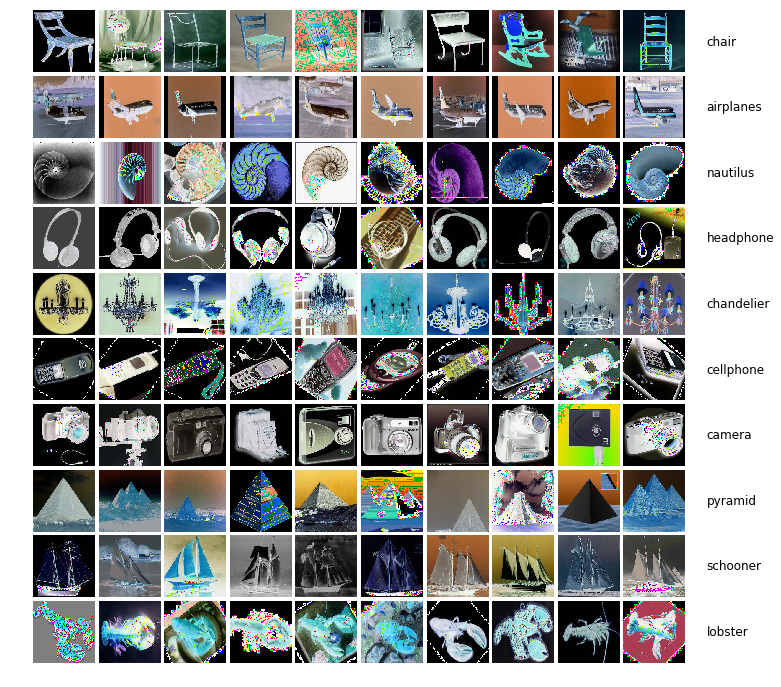

In [10]:
num_category=10
num_images=10
fig = plt.figure(1,figsize=(20,12))
grid = ImageGrid(fig, 111, nrows_ncols=(num_category,num_images), axes_pad=0.05)
i = 0
for category_id, category in enumerate(labels[:num_category]):
    for file in dfX[dfX['category']==category]['file'].values[:num_images]:
        ax=grid[i]
        img = read_img(os.path.join(data_dir,file),(224,224))
        ax.imshow(img)
        ax.axis('off')
        if i%num_category == num_category-1:
            ax.text(300,112,file.split('/')[2], verticalalignment='center',fontsize=12)
        i += 1
plt.show()

In [ ]:
for category in labels:
    print('{:>12}-> {} images'.format(category, len(os.listdir(os.path.join(data_dir, category)))))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=seed)

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [12]:
number_of_classes = 102
Y_train = np_utils.to_categorical(y_train, number_of_classes)
Y_test = np_utils.to_categorical(y_test, number_of_classes)


In [13]:
gen = ImageDataGenerator(width_shift_range=.2, 
                             height_shift_range=.2,
                          zoom_range=0.2)

test_gen = ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=16)
test_generator = test_gen.flow(X_test, Y_test, batch_size=16)

In [14]:
from keras.applications. vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [15]:
def add_new_last_layer(base_model, nb_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(input=base_model.input, output=predictions)
    return model

base_model = ResNet50(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
model = add_new_last_layer(base_model, 102)

In [16]:
base_model1 = InceptionResNetV2(weights='imagenet',include_top=False)
model = add_new_last_layer(base_model1, 102)

/home/rsathyam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [ ]:
model.summary()

In [17]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr = 1e-3,momentum = 0.9),metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [18]:
history = model.fit_generator(train_generator, epochs=20, 
                    validation_data=test_generator)

Epoch 1/20
458/458 [==============================] - 177s 385ms/step - loss: 2.0810 - acc: 0.5775 - val_loss: 0.6652 - val_acc: 0.8639
Epoch 2/20
458/458 [==============================] - 150s 328ms/step - loss: 0.4840 - acc: 0.8876 - val_loss: 0.2923 - val_acc: 0.9202
Epoch 3/20
458/458 [==============================] - 150s 328ms/step - loss: 0.2429 - acc: 0.9387 - val_loss: 0.2509 - val_acc: 0.9267
Epoch 4/20
458/458 [==============================] - 150s 328ms/step - loss: 0.1661 - acc: 0.9587 - val_loss: 0.2072 - val_acc: 0.9459
Epoch 5/20
458/458 [==============================] - 150s 328ms/step - loss: 0.1214 - acc: 0.9681 - val_loss: 0.2081 - val_acc: 0.9475
Epoch 6/20
458/458 [==============================] - 150s 328ms/step - loss: 0.0936 - acc: 0.9741 - val_loss: 0.2097 - val_acc: 0.9470
Epoch 7/20
458/458 [==============================] - 150s 328ms/step - loss: 0.0734 - acc: 0.9805 - val_loss: 0.1910 - val_acc: 0.9519
Epoch 8/20
458/458 [============================

In [21]:
import pickle
with open('./trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [22]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

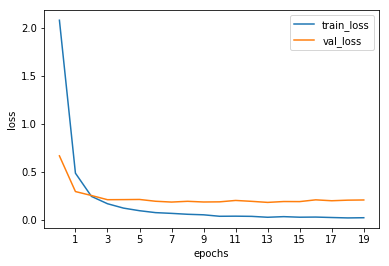

In [42]:
ep = np.arange(20)
plt.plot(ep, train_loss, label="train_loss")
plt.plot(ep, val_loss, label="val_loss")
plt.xticks(np.arange(min(ep+1), max(ep)+1, 2.0))
# plt.yticks(np.arange(min(train_loss), max(train_loss)))
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.show();
plt.savefig('loss.png')

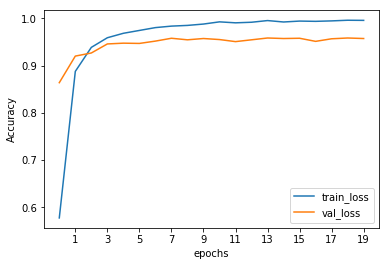

In [43]:
ep = np.arange(20)
plt.plot(ep, train_acc, label="train_loss")
plt.plot(ep, val_acc, label="val_loss")
plt.xticks(np.arange(min(ep+1), max(ep)+1, 2.0))
# plt.yticks(np.arange(min(train_loss), max(train_loss)))
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
# plt.show();
plt.savefig('acc.png')

In [41]:
score = model.evaluate(X_test, Y_test)
print()
print('Test loss: ', score[0])
print('Test Accuracy', score[1])


1829/1829 [==============================] - 11s 6ms/step

Test loss:  0.20437525652966143
Test Accuracy 0.9573537452159651


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

# Predict the values from the validation dataset
predY = model.predict(X_test)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(Y_test, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = labels) 